# 01 - Data Overview
Quick look at processed tables and basic distributions.

In [2]:
import sys
from pathlib import Path

def _find_root():
    cand = Path.cwd()
    for c in [cand, *cand.parents]:
        if (c / 'src').exists() and (c / 'data').exists():
            return c
    return cand

ROOT = _find_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

raw_candidates = [
    ROOT / 'data/raw/data_v2.json',
    ROOT.parent / 'data/raw/data_v2.json',
]
raw_path = next((p for p in raw_candidates if p.exists()), None)
if raw_path is None:
    raise FileNotFoundError(f'data/raw/data_v2.json introuvable. Cherché: {raw_candidates}')

processed_dir = ROOT / 'data/processed'
processed_dir.mkdir(parents=True, exist_ok=True)
FORCE_REBUILD = True  # met à False si tu veux juste consommer les parquets existants

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.dota_data import read_processed_tables, match_header, kill_participation, write_parquet_tables

sns.set_theme(style='whitegrid')

matches_file = processed_dir / 'matches.parquet'
needs_rebuild = FORCE_REBUILD or not matches_file.exists()
if matches_file.exists() and not FORCE_REBUILD:
    needs_rebuild = raw_path.stat().st_mtime > matches_file.stat().st_mtime

if needs_rebuild:
    print(f'Rebuild des parquets depuis {raw_path}')
    write_parquet_tables(raw_path, processed_dir)
else:
    print(f'Parquets déjà présents (utilisation): {matches_file}')

tables = read_processed_tables(processed_dir)
matches = match_header(tables['matches'])
players = tables['players']
objectives = tables['objectives']
teamfights = tables['teamfights']

print('Shapes:', matches.shape, players.shape, objectives.shape, teamfights.shape)
(matches.shape, players.shape, objectives.shape, teamfights.shape)


Rebuild des parquets depuis /home/ju/Documents/Dev/Dota-Datas/data/raw/data_v2.json
Shapes: (3879, 11) (38790, 151) (101435, 11) (204380, 19)


((3879, 11), (38790, 151), (101435, 11), (204380, 19))

In [3]:
# Winrate global et par patch
winrate = matches.select(pl.col("radiant_win").mean().alias("radiant_winrate"))
winrate_patch = matches.group_by("patch").agg(pl.col("radiant_win").mean().alias("radiant_winrate"))
display(winrate)
display(winrate_patch.sort("patch"))

radiant_winrate
f64
0.500902


patch,radiant_winrate
i64,f64
56,0.501534
57,0.519577
58,0.492989


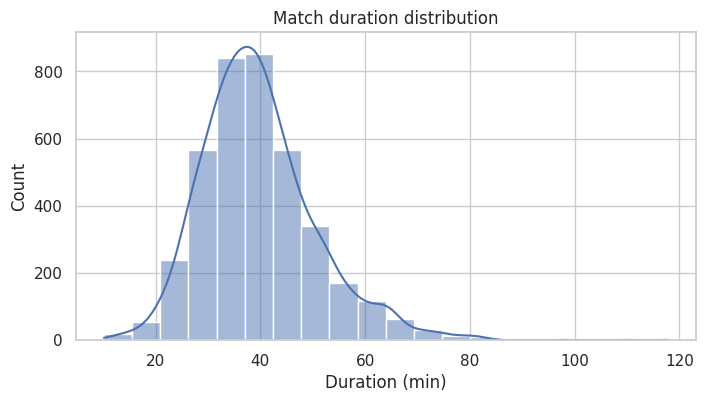

In [4]:
# Distribution des durees (minutes)
df_matches = matches.to_pandas()
df_matches["duration_min"] = df_matches["duration"] / 60
plt.figure(figsize=(8,4))
sns.histplot(df_matches["duration_min"], bins=20, kde=True)
plt.xlabel("Duration (min)")
plt.title("Match duration distribution")
plt.show()

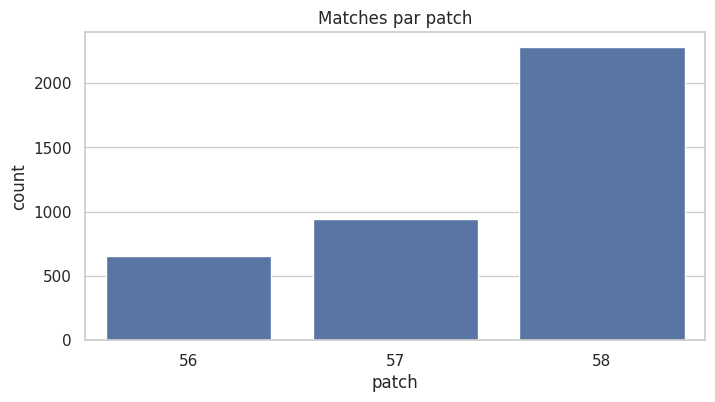

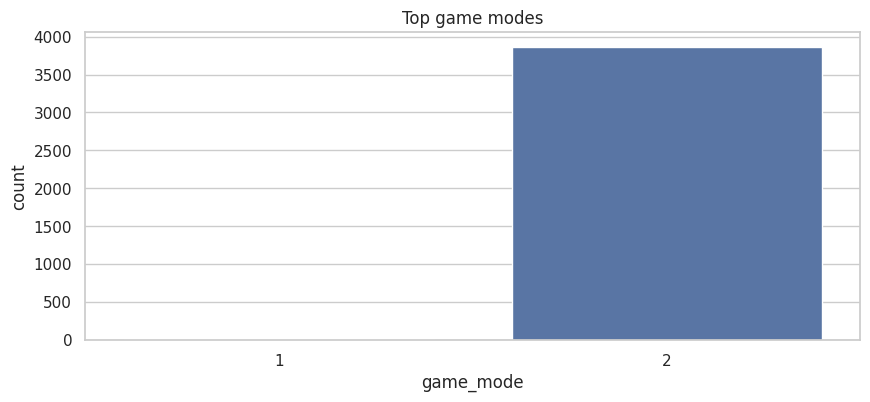

In [5]:
# Patch et modes les plus frequents
plt.figure(figsize=(8,4))
sns.countplot(data=df_matches, x="patch")
plt.title("Matches par patch")
plt.show()

plt.figure(figsize=(10,4))
top_modes = df_matches["game_mode"].value_counts().head(10)
sns.barplot(x=top_modes.index, y=top_modes.values)
plt.title("Top game modes")
plt.xlabel("game_mode")
plt.ylabel("count")
plt.show()

In [6]:
# Valeurs manquantes (top 10)
nulls = (matches.null_count() / len(matches)).to_pandas().T
nulls = nulls.melt(var_name="column", value_name="null_ratio")
nulls = nulls.sort_values("null_ratio", ascending=False)
display(nulls.head(10))

,column,null_ratio
10,0,0.012374
1,0,0.000000
0,0,0.000000
2,0,0.000000
3,0,0.000000
5,0,0.000000
4,0,0.000000
6,0,0.000000
7,0,0.000000
8,0,0.000000


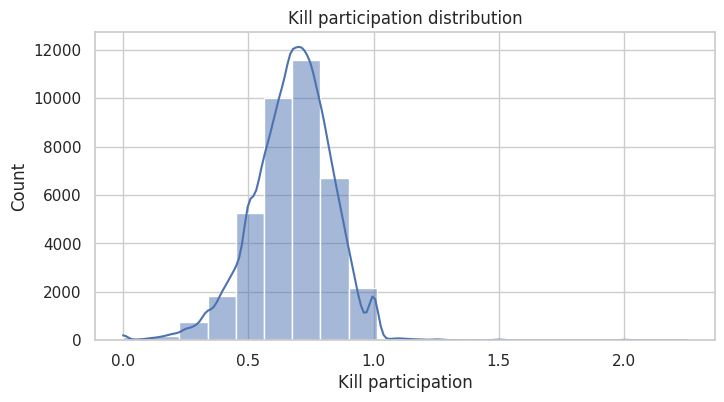

,match_id,player_slot,hero_id,kills,assists,team_kills,kill_participation
count,3.879000e+04,38790.000000,38790.000000,38790.000000,38790.000000,38790.000000,38785.000000
mean,8.351831e+09,66.000000,68.578061,4.871178,11.732534,24.355891,0.676021
std,1.421838e+08,64.016448,39.115701,4.009352,6.922969,11.334721,0.157312
min,8.111128e+09,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,8.229754e+09,2.000000,37.000000,2.000000,6.000000,15.000000,0.583333
50%,8.346335e+09,66.000000,66.000000,4.000000,11.000000,24.000000,0.687500
75%,8.488237e+09,130.000000,100.000000,7.000000,16.000000,33.000000,0.777778
max,8.594671e+09,132.000000,145.000000,31.000000,53.000000,80.000000,2.250000


In [7]:
# Kill participation distribution
kp = kill_participation(players).to_pandas()
plt.figure(figsize=(8,4))
sns.histplot(kp["kill_participation"].dropna(), bins=20, kde=True)
plt.xlabel("Kill participation")
plt.title("Kill participation distribution")
plt.show()
kp.describe()